In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats import weightstats
%matplotlib inline

In [2]:
df = pd.read_csv('stud_math.csv')

# Предобработка

In [3]:
def fill_with_none(var):
    '''функция заполнения пустых ячеек None'''
    var = var.apply(lambda x: None if pd.isnull(x) else x)
    return var


def iqr(var):
    '''функция расчета параметров межквартильного интервала'''
    global perc25, perc75, IQR
    IQR = df[var].quantile(0.75) - df[var].quantile(0.25)
    perc25 = df[var].quantile(0.25)
    perc75 = df[var].quantile(0.75)

    print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

    
def label_encoding(data, col):
    '''функция перевода категориального признака в числовой'''
    unique_values = data[col].dropna().unique()
    enconding_values = range(len(unique_values))
    encoding_dict = dict(zip(unique_values, enconding_values))
    print(encoding_dict)
    return data[col].replace(encoding_dict, inplace=True)   


def fill_mod(col):
    '''функция заполнения пропусков модой'''
    df[col] = df[col].fillna(df[col].mode()[0])

    
def fill_med(col):
    '''функция заполнения пропусков медианой'''
    df[col] = df[col].fillna(df[col].median())
    

def fill_aver(col):
    '''функция заполнения пропусков средним арифметическим'''
    df[col] = df[col].fillna(df[col].mean())

# Цель проекта

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, провдится разведывательный анализ данных. 

**Цель данного проекта: провести разведывательный анализ данных и составить отчёт по его результатам.**

# Знакомство с датасетом

Переменные, которые содержит датасет:
1. school — аббревиатура школы, в которой учится ученик
2. sex — пол ученика ('F' - женский, 'M' - мужской)
3. age — возраст ученика (от 15 до 22)
4. address — тип адреса ученика ('U' - городской, 'R' - за городом)
5. famsize — размер семьи('LE3' <= 3, 'GT3' >3)
6. Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
7. Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
8. Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
9. Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
10. Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
11. reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
12. guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
13. traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
14. studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
15. failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
16. schoolsup — дополнительная образовательная поддержка (yes или no)
17. famsup — семейная образовательная поддержка (yes или no)
18. paid — дополнительные платные занятия по математике (yes или no)
19. activities — дополнительные внеучебные занятия (yes или no)
20. nursery — посещал детский сад (yes или no)
21. higher — хочет получить высшее образование (yes или no)
22. internet — наличие интернета дома (yes или no)
23. romantic — в романтических отношениях (yes или no)
24. famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
25. freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
26. goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
27. health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
28. absences — количество пропущенных занятий
29. score — баллы по госэкзамену по математике

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Чтобы не путаться впоследствии, названия всех столбцов сделаем строчными буквами: 

In [5]:
df.columns = [col.lower() for col in df.columns]

Переименуем столбец studytime, granular, чтобы он был в приемлемом для работы формате:

In [6]:
df.rename(columns={'studytime, granular': 'studytime_granular'}, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   pstatus             350 non-null    object 
 6   medu                392 non-null    float64
 7   fedu                371 non-null    float64
 8   mjob                376 non-null    object 
 9   fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

In [8]:
df

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,...,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,...,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,...,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,...,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


Оценим количество пропусков в колонках. 

In [9]:
for col in df.columns:
    pct_missing = df[col].isna().mean()
    print(f'{col} - {pct_missing :.1%}')

school - 0.0%
sex - 0.0%
age - 0.0%
address - 4.3%
famsize - 6.8%
pstatus - 11.4%
medu - 0.8%
fedu - 6.1%
mjob - 4.8%
fjob - 9.1%
reason - 4.3%
guardian - 7.8%
traveltime - 7.1%
studytime - 1.8%
failures - 5.6%
schoolsup - 2.3%
famsup - 9.9%
paid - 10.1%
activities - 3.5%
nursery - 4.1%
studytime_granular - 1.8%
higher - 5.1%
internet - 8.6%
romantic - 7.8%
famrel - 6.8%
freetime - 2.8%
goout - 2.0%
health - 3.8%
absences - 3.0%
score - 1.5%


Пропусков относительно немного, удалять колонки, скорее всего, не придется.

Количество пропусков в абсолютных значениях:

In [10]:
null_data = df.isnull().sum()
null_data[null_data>0]

address               17
famsize               27
pstatus               45
medu                   3
fedu                  24
mjob                  19
fjob                  36
reason                17
guardian              31
traveltime            28
studytime              7
failures              22
schoolsup              9
famsup                39
paid                  40
activities            14
nursery               16
studytime_granular     7
higher                20
internet              34
romantic              31
famrel                27
freetime              11
goout                  8
health                15
absences              12
score                  6
dtype: int64

Есть два очень похожих друг на друга столбца:

In [11]:
df.studytime

0      2.0
1      2.0
2      2.0
3      3.0
4      2.0
      ... 
390    2.0
391    1.0
392    1.0
393    1.0
394    1.0
Name: studytime, Length: 395, dtype: float64

In [12]:
df['studytime_granular']

0     -6.0
1     -6.0
2     -6.0
3     -9.0
4     -6.0
      ... 
390   -6.0
391   -3.0
392   -3.0
393   -3.0
394   -3.0
Name: studytime_granular, Length: 395, dtype: float64

На первый взгляд, значения различаются в -3 раза.
Потом проверим корреляцию. Если коэф. корреляции близок к +/- 1, то второй удалим.

# Первичный анализ числовых переменных

## score


Начнем с целевой переменной. Здесь точно придется удалять строки с пустыми значениями. С этими строками уйдут и значения из других переменных, может быть и не нужные. Возможно, уменьшим себе работу по анализу других переменных.

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

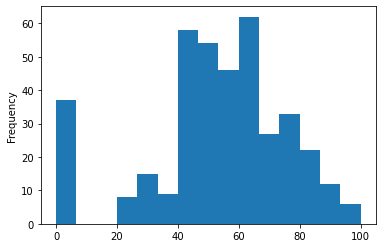

In [13]:
df.score.plot.hist(bins=15)
df.score.describe()

Распределение без аномалий, приблизительно напоминает нормальное (за исключением нулевых баллов).

Уберем нули и посмотрим, что даст нормализация логарифмированием:

<AxesSubplot:>

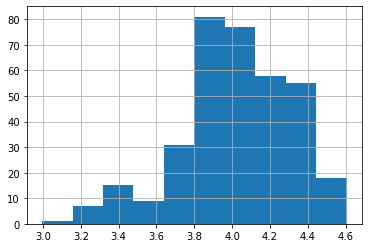

In [14]:
df1 = df[df.score > 0]
df1.score.apply(np.log).hist(bins=10)

Не очень результативно. Появляется отрицательное смещение. Приближения к нормальному распределению не произошло.

Нулевые значения, видимо, нельзя удалять, т.к. возможно, что кто-то получил 0 баллов за госэкзамен. Хотя разрыв между 0 и 20 смущает. Странно, что либо не сдал, либо сразу набрал от 20 баллов. Тут нужно узнавать, по какой системе эти баллы рассчитываются. Пока оставим нули.


В дальнейшем, следует проанализировать эту переменную отдельно с нулями и без.

In [15]:
df.score.value_counts()

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
60.0     31
40.0     31
45.0     27
70.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
20.0      1
100.0     1
Name: score, dtype: int64

Удалим строки с пустыми значениями в переменной score:

In [16]:
df.dropna(subset=['score'], inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              389 non-null    object 
 1   sex                 389 non-null    object 
 2   age                 389 non-null    int64  
 3   address             374 non-null    object 
 4   famsize             362 non-null    object 
 5   pstatus             344 non-null    object 
 6   medu                386 non-null    float64
 7   fedu                365 non-null    float64
 8   mjob                370 non-null    object 
 9   fjob                353 non-null    object 
 10  reason              372 non-null    object 
 11  guardian            358 non-null    object 
 12  traveltime          361 non-null    float64
 13  studytime           382 non-null    float64
 14  failures            367 non-null    float64
 15  schoolsup           380 non-null    object 
 16  famsup  

Проверим переменную на выбросы:

In [18]:
iqr('score')
 

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


Все значения лежат в пределах границ выбросов. Нулевые значения оставляем.

## age

Проверим основные статистики числового ряда возрастов. 

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

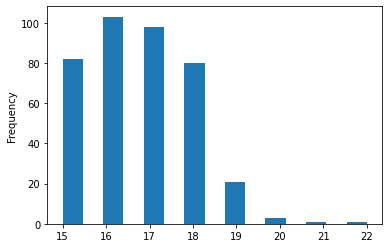

In [19]:
df.age.plot.hist(bins=15)
df.age.describe()

Аномалий не наблюдается, выбросов нет. Распределение смещено вправо.

## medu

Проверим числовой столбец образования матери.

In [20]:
display(pd.DataFrame(df.medu.value_counts()))

,medu
4.0,131
2.0,100
3.0,96
1.0,56
0.0,3


count    386.000000
mean       2.766839
std        1.094277
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

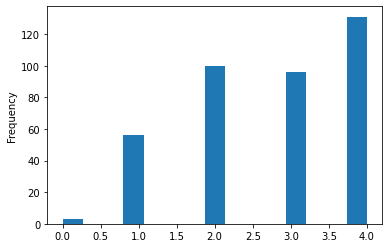

In [21]:
df.medu.plot.hist(bins=15)
df.medu.describe()

Аномалий не наблюдается, выбросов нет. 

Заполним пропуски None:

In [22]:
fill_with_none(df.medu)

0      4.0
1      1.0
2      1.0
3      4.0
4      3.0
      ... 
390    2.0
391    3.0
392    1.0
393    3.0
394    1.0
Name: medu, Length: 389, dtype: float64

Данных в датасете не слишком много, целесообразно, по возможности, беречь каждую строку.


Можно заполнить пустые ячейки константой, которая вносит минимальные искажения в исходное распределение.


Заполним пропуски модой:

In [23]:
fill_mod('medu')

count    389.000000
mean       2.776350
std        1.095377
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

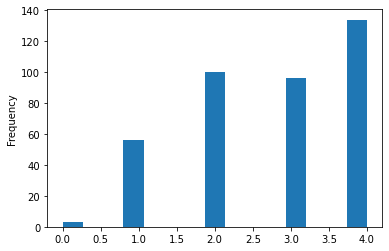

In [24]:
df.medu.plot.hist(bins=15)
df.medu.describe()

## fedu

Проверим числовой столбец образования отца.

In [25]:
display(pd.DataFrame(df.fedu.value_counts()))
# pd.Series(df.fedu).value_counts()
# df.fedu.value_counts()

,fedu
2.0,105
3.0,94
4.0,88
1.0,75
0.0,2
40.0,1


Имеется явный выброс: 40

In [26]:
df.fedu.isnull().sum()


24

Проверим, чем заполнены оставшиеся 24 строки:

In [27]:
df[(df.fedu != 1)&(df.fedu != 2)&(df.fedu != 3)&(df.fedu != 4)&(df.fedu != 40)&(df.fedu !=0)]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
21,GP,M,15,U,GT3,T,4.0,NaN,health,health,...,-3.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
42,GP,M,15,U,GT3,T,4.0,NaN,services,teacher,...,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,2.0,90.0
46,GP,F,16,U,LE3,A,3.0,NaN,other,services,...,-6.0,yes,yes,no,2.0,3.0,5.0,3.0,12.0,55.0
57,GP,M,15,U,GT3,T,4.0,NaN,teacher,health,...,-6.0,yes,no,no,3.0,2.0,2.0,5.0,4.0,75.0
58,GP,M,15,U,LE3,T,1.0,NaN,other,at_home,...,-6.0,yes,yes,no,4.0,3.0,2.0,5.0,2.0,45.0
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,...,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,...,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
142,GP,F,15,U,GT3,T,4.0,NaN,teacher,services,...,-9.0,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,...,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
161,GP,M,15,R,GT3,T,3.0,NaN,other,NaN,...,-6.0,yes,yes,yes,4.0,4.0,4.0,3.0,6.0,35.0


Найдем строку с выбросом:

In [28]:
df.loc[(df.fedu == 40)]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,...,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


Можно предположить, что 40 - это опечатка и здесь должно быть 4. Заменим 40 на 4 и пройдемся по
остальным значениям заменяя пустые на None (если что-то не заметили):

In [29]:
fill_with_none(df.fedu)
df.loc[11, 'fedu'] = 4

Проверим, что получилось:

In [30]:
df.fedu.value_counts()

2.0    105
3.0     94
4.0     89
1.0     75
0.0      2
Name: fedu, dtype: int64

Добавилась еще одна ячейка со сзначением 4.

count    365.000000
mean       2.528767
std        1.088082
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: fedu, dtype: float64

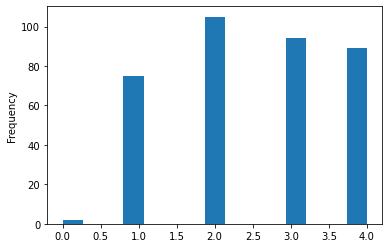

In [31]:
df.fedu.plot.hist(bins=15)
df.fedu.describe()

Аномалий не наблюдается, выбросов нет.

In [32]:
df.loc[:, ['fedu']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fedu    365 non-null    float64
dtypes: float64(1)
memory usage: 14.2 KB


Заполним пропуски модой:

In [33]:
fill_mod('fedu')

count    389.000000
mean       2.496144
std        1.061564
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: fedu, dtype: float64

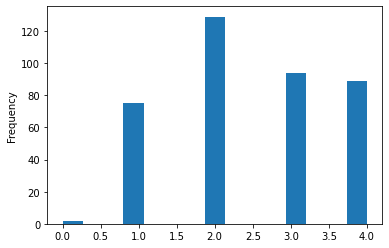

In [34]:
df.fedu.plot.hist(bins=15)
df.fedu.describe()

## traveltime

count    361.000000
mean       1.434903
std        0.692660
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

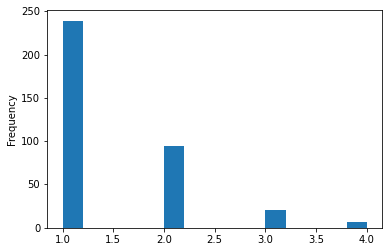

In [35]:
df.traveltime.plot.hist(bins=15)
df.traveltime.describe()

In [36]:
df.traveltime.value_counts()

1.0    239
2.0     94
3.0     21
4.0      7
Name: traveltime, dtype: int64

Аномалий не наблюдается, выбросов нет.

Посмотрим, сколько пустых строк в переменной:

In [37]:
df.traveltime.isnull().sum()

28

Заполним пустые ячейки None:

In [38]:
fill_with_none(df.traveltime)

0      2.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
390    1.0
391    2.0
392    1.0
393    3.0
394    1.0
Name: traveltime, Length: 389, dtype: float64

Здесь, также, меньше искажений в распределение привносит заполнение пустых ячеек модой.

In [39]:
fill_mod('traveltime')

count    389.000000
mean       1.403599
std        0.676625
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

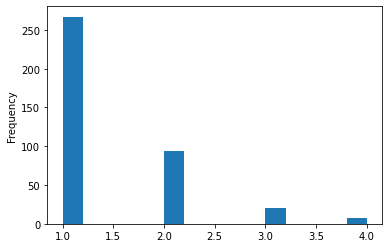

In [40]:
df.traveltime.plot.hist(bins=15)
df.traveltime.describe()

In [41]:
df.loc[:, ['traveltime']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  389 non-null    float64
dtypes: float64(1)
memory usage: 14.2 KB


## studytime

count    382.000000
mean       2.036649
std        0.847239
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

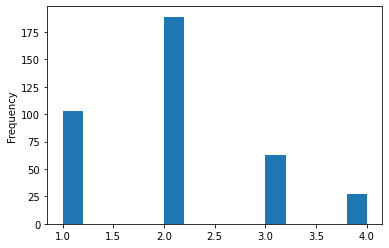

In [42]:
df.studytime.plot.hist(bins=15)
df.studytime.describe()

In [43]:
df.studytime.value_counts()

2.0    189
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64

Аномалий не наблюдается, выбросов нет.

Посмотрим, сколько пустых строк в переменной:

In [44]:
df.studytime.isnull().sum()

7

Заполним пустые ячейки None:

In [45]:
fill_with_none(df.studytime)

0      2.0
1      2.0
2      2.0
3      3.0
4      2.0
      ... 
390    2.0
391    1.0
392    1.0
393    1.0
394    1.0
Name: studytime, Length: 389, dtype: float64

Заполним пропуски константой (mode):

In [46]:
fill_mod('studytime')

count    389.000000
mean       2.035990
std        0.839575
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

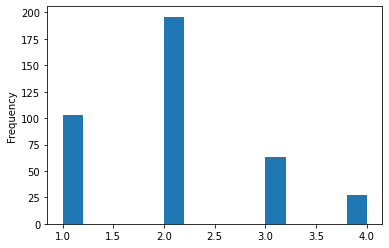

In [47]:
df.studytime.plot.hist(bins=15)
df.studytime.describe()

## failures

count    367.000000
mean       0.326975
std        0.729479
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

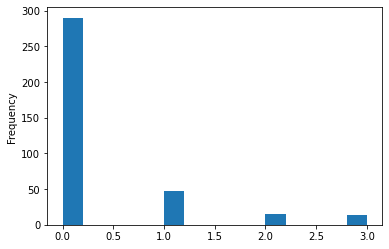

In [48]:
df.failures.plot.hist(bins=15)
df.failures.describe()

In [49]:
df.failures.value_counts()

0.0    290
1.0     48
2.0     15
3.0     14
Name: failures, dtype: int64

Не очень понятно, что означает эта переменная. Что подразумевается под "внеучебными неудачами".

Заполним пропуски:

In [50]:
df.failures.isnull().sum()

22

In [51]:
fill_with_none(df.failures)

0      0.0
1      0.0
2      3.0
3      0.0
4      0.0
      ... 
390    2.0
391    0.0
392    3.0
393    0.0
394    0.0
Name: failures, Length: 389, dtype: float64

In [52]:
fill_mod('failures')

count    389.000000
mean       0.308483
std        0.712521
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

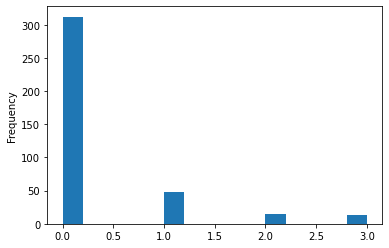

In [53]:
df.failures.plot.hist(bins=15)
df.failures.describe()

## studytime_granular

Посмотрим на кореляцию этой пременной с переменной studytime:

In [54]:
df['studytime'].corr(df['studytime_granular'])

-0.9999999999999993

In [55]:
clmns = ['studytime', 'studytime_granular']
df.loc[:,clmns].corr()

,studytime,studytime_granular
studytime,1.0,-1.0
studytime_granular,-1.0,1.0


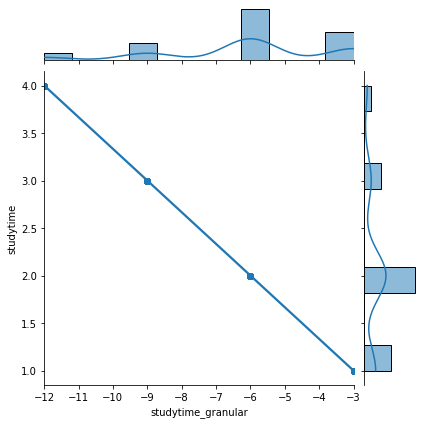

In [56]:
sns.jointplot(x = 'studytime_granular', y = 'studytime', data = df, kind = 'reg')

<AxesSubplot:xlabel='studytime_granular', ylabel='studytime'>

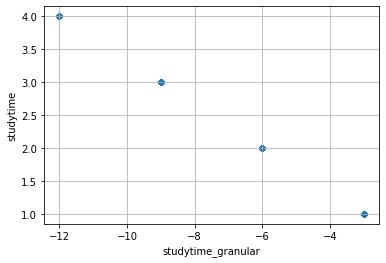

In [57]:
df.plot(x = 'studytime_granular', 
        y = 'studytime', 
        kind = 'scatter', 
        grid = True, 
        title = '')

Это явные дубликаты и переменную studytime_granular можно удалить. К тому же, она отсутствует в описании датасета.

In [58]:
df.drop(['studytime_granular'], axis=1, inplace=True)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   pstatus     344 non-null    object 
 6   medu        389 non-null    float64
 7   fedu        389 non-null    float64
 8   mjob        370 non-null    object 
 9   fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  389 non-null    float64
 13  studytime   389 non-null    float64
 14  failures    389 non-null    float64
 15  schoolsup   380 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        350 non-null    object 
 18  activities  375 non-null    object 
 19  nursery     374 non-null    o

## famrel

count    362.000000
mean       3.930939
std        0.931554
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

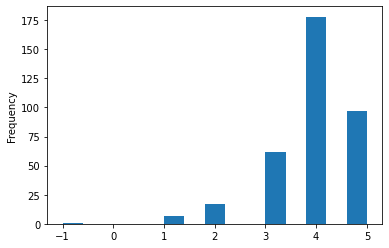

In [60]:
df.famrel.plot.hist(bins=15)
df.famrel.describe()

Есть явный выброс: -1. У нас в этой перменной 5-бальная шкала.

In [61]:
(df.famrel == -1).value_counts()

False    388
True       1
Name: famrel, dtype: int64

Локализуем строку с выбросом:

In [62]:
df.loc[(df.famrel == -1)]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,...,no,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


И снова, не целесообразно избавляться от этой строки с выбросом. В ней почти все данные присутствуют.
Сделаем допущение об опечатке. Заменим -1 на 1.

In [63]:
df.loc[25, 'famrel'] = 1
df.loc[25, 'famrel']

1.0

Заполним пустые строки:

In [64]:
fill_with_none(df.famrel)

0      4.0
1      5.0
2      4.0
3      3.0
4      4.0
      ... 
390    5.0
391    2.0
392    5.0
393    4.0
394    3.0
Name: famrel, Length: 389, dtype: float64

count    362.000000
mean       3.936464
std        0.907858
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

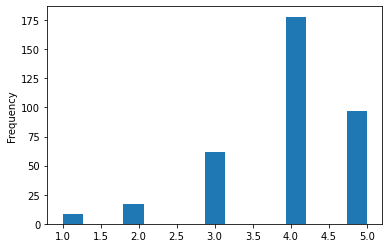

In [65]:
df.famrel.plot.hist(bins=15)
df.famrel.describe()

Распределение смещено влево.

Заполним недостающие данные значениями моды:

In [66]:
fill_mod('famrel')

count    389.000000
mean       3.940874
std        0.875850
min        1.000000
25%        4.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: famrel, dtype: float64

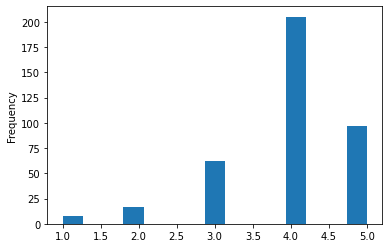

In [67]:
df.famrel.plot.hist(bins=15)
df.famrel.describe()

## freetime

count    380.000000
mean       3.223684
std        0.993364
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

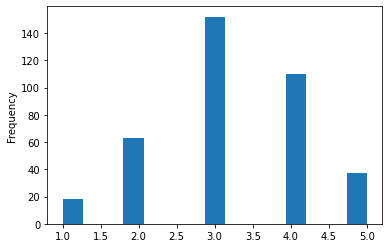

In [68]:
df.freetime.plot.hist(bins=15)
df.freetime.describe()

In [69]:
df.freetime.value_counts()

3.0    152
4.0    110
2.0     63
5.0     37
1.0     18
Name: freetime, dtype: int64

Аномалий не наблюдается, выбросов нет.

Заполним пропуски:

In [70]:
fill_with_none(df.freetime)

0      3.0
1      3.0
2      3.0
3      2.0
4      3.0
      ... 
390    5.0
391    4.0
392    5.0
393    4.0
394    2.0
Name: freetime, Length: 389, dtype: float64

Заполним недостающие данные значениями медианы:

In [71]:
fill_med('freetime')

count    389.000000
mean       3.218509
std        0.982353
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

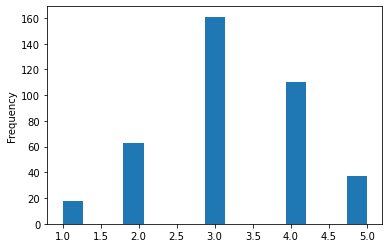

In [72]:
df.freetime.plot.hist(bins=15)
df.freetime.describe()

## goout

count    382.000000
mean       3.094241
std        1.116104
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

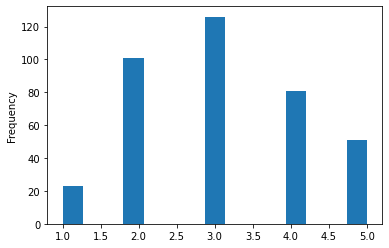

In [73]:
df.goout.plot.hist(bins=15)
df.goout.describe()

In [74]:
df.goout.value_counts()

3.0    126
2.0    101
4.0     81
5.0     51
1.0     23
Name: goout, dtype: int64

Аномалий не наблюдается, выбросов нет.

Заполним пропуски:

In [75]:
fill_with_none(df.goout)

0      4.0
1      3.0
2      2.0
3      2.0
4      2.0
      ... 
390    4.0
391    5.0
392    3.0
393    1.0
394    3.0
Name: goout, Length: 389, dtype: float64

Заполним недостающие значения медианой:

In [76]:
fill_med('goout')

count    389.000000
mean       3.092545
std        1.106062
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

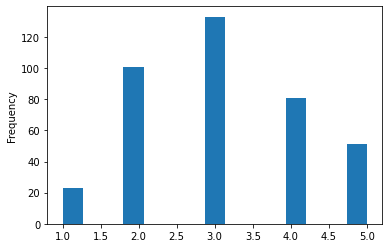

In [77]:
df.goout.plot.hist(bins=15)
df.goout.describe()

## health

count    374.000000
mean       3.529412
std        1.402006
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

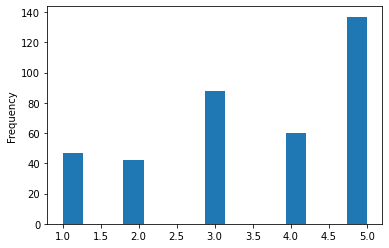

In [78]:
df.health.plot.hist(bins=15)
df.health.describe()

In [79]:
df.health.value_counts()

5.0    137
3.0     88
4.0     60
1.0     47
2.0     42
Name: health, dtype: int64

Аномалий не наблюдается, выбросов нет.

Заполним пропуски:

In [80]:
fill_with_none(df.health)

0      3.0
1      3.0
2      3.0
3      5.0
4      5.0
      ... 
390    4.0
391    2.0
392    3.0
393    5.0
394    5.0
Name: health, Length: 389, dtype: float64

Пустые значения заполним модой:

In [81]:
fill_mod('health')

count    389.000000
mean       3.586118
std        1.403572
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

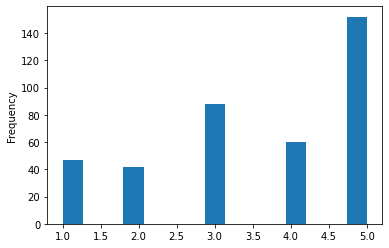

In [82]:
df.health.plot.hist(bins=15)
df.health.describe()

## absences

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

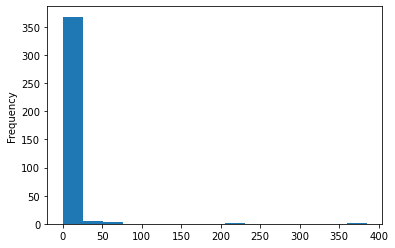

In [83]:
df.absences.plot.hist(bins=15)
df.absences.describe()

Есть выбросы. Оценим их с помощью формулы интерквартильного расстояния:

In [84]:
iqr('absences')

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


In [85]:
df.absences.value_counts()

0.0      110
2.0       60
4.0       52
6.0       30
8.0       20
10.0      17
14.0      12
12.0      12
16.0       7
3.0        7
7.0        6
18.0       5
5.0        5
20.0       4
9.0        3
22.0       3
1.0        3
13.0       2
15.0       2
11.0       2
40.0       1
38.0       1
56.0       1
23.0       1
24.0       1
25.0       1
385.0      1
17.0       1
75.0       1
21.0       1
212.0      1
28.0       1
19.0       1
26.0       1
30.0       1
54.0       1
Name: absences, dtype: int64

Посмотрим на строки с некоторыми выбросами:

In [86]:
df.loc[(df.absences == 385)]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,...,yes,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0


In [87]:
df.loc[(df.absences == 212)]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,...,yes,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0


In [88]:
df.loc[(df.absences == 54)]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,...,yes,yes,yes,no,4.0,3.0,3.0,5.0,54.0,55.0


Оставлять только те значения, которые лежат внутри межквартильного размаха (df = df.loc[df.absences.between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)]), на мой взгляд, не целесообразно. Будет потеряно много строк из датасета.
Данные в строках хорошие. Ученики с большим количеством пропусков имеют средний балл (кроме рекордсмена по пропущенным занятиям, который может оказаться продвинутым, которому не нужно ходить на уроки).
Поэтому, пока, меньшим из зол будет заменить данные вне пределов размаха на None.


In [89]:
df.absences = df.absences.apply(lambda x: None if x > 20 else x)

In [90]:
df.absences.value_counts()

0.0     110
2.0      60
4.0      52
6.0      30
8.0      20
10.0     17
12.0     12
14.0     12
16.0      7
3.0       7
7.0       6
18.0      5
5.0       5
20.0      4
1.0       3
9.0       3
11.0      2
15.0      2
13.0      2
19.0      1
17.0      1
Name: absences, dtype: int64

In [91]:
df.loc[:, ['absences']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  361 non-null    float64
dtypes: float64(1)
memory usage: 14.2 KB


Заполним пропуски, которые, возможно, присутствовали в датасете до наших действий выше:

In [92]:
fill_with_none(df.absences)

0       6.0
1       4.0
2      10.0
3       2.0
4       4.0
       ... 
390     NaN
391     3.0
392     3.0
393     0.0
394     5.0
Name: absences, Length: 389, dtype: float64

count    361.000000
mean       4.609418
std        4.989413
min        0.000000
25%        0.000000
50%        4.000000
75%        7.000000
max       20.000000
Name: absences, dtype: float64

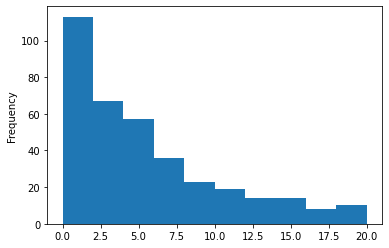

In [93]:
df.absences.plot.hist(bins=10)
df.absences.describe()

Заменим пропуски модой:

In [94]:
fill_mod('absences')

count    389.000000
mean       4.277635
std        4.951834
min        0.000000
25%        0.000000
50%        2.000000
75%        6.000000
max       20.000000
Name: absences, dtype: float64

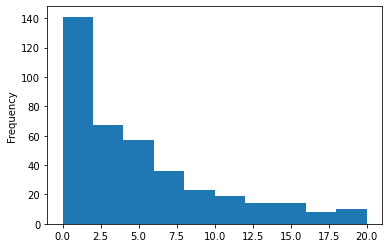

In [95]:
df.absences.plot.hist(bins=10)
df.absences.describe()

# Кодировка номинальных переменных

Составим список номинальных переменных:

In [96]:
l = ['school',
     'sex',
     'address',
     'famsize',
     'pstatus',
     'mjob',
     'fjob',
     'reason',
     'guardian',
     'schoolsup',
     'famsup',
     'paid',
     'activities',
     'nursery',
     'higher',
     'internet',
     'romantic'     
    ]

Заполним пустые значения None:

In [97]:
for i in l:
    fill_with_none(df[i])

Запустим функцию кодирования номинальных переменных по списку:

In [98]:
for i in l:
    label_encoding(df, i)

{'GP': 0, 'MS': 1}
{'F': 0, 'M': 1}
{'U': 0, 'R': 1}
{'GT3': 0, 'LE3': 1}
{'A': 0, 'T': 1}
{'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4}
{'teacher': 0, 'other': 1, 'health': 2, 'services': 3, 'at_home': 4}
{'course': 0, 'other': 1, 'home': 2, 'reputation': 3}
{'mother': 0, 'father': 1, 'other': 2}
{'yes': 0, 'no': 1}
{'no': 0, 'yes': 1}
{'no': 0, 'yes': 1}
{'no': 0, 'yes': 1}
{'yes': 0, 'no': 1}
{'yes': 0, 'no': 1}
{'yes': 0, 'no': 1}
{'no': 0, 'yes': 1}


Посмотрим, что получилось:

In [99]:
df[l]

,school,sex,address,famsize,pstatus,mjob,fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,0,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
1,0,0,0.0,0.0,NaN,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
3,0,0,0.0,0.0,1.0,1.0,NaN,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0,0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,0.0,1.0,0.0,3.0,3.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
391,1,1,0.0,1.0,1.0,3.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
392,1,1,1.0,0.0,1.0,2.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,NaN,1.0,0.0
393,1,1,1.0,1.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0


Заполним пропуски модой:

In [100]:
for i in l:
    fill_mod(i)

Приведем все данные к одному типу:

In [101]:
df[['school', 'sex', 'age']] = df[['school', 'sex', 'age']].astype(float)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    float64
 1   sex         389 non-null    float64
 2   age         389 non-null    float64
 3   address     389 non-null    float64
 4   famsize     389 non-null    float64
 5   pstatus     389 non-null    float64
 6   medu        389 non-null    float64
 7   fedu        389 non-null    float64
 8   mjob        389 non-null    float64
 9   fjob        389 non-null    float64
 10  reason      389 non-null    float64
 11  guardian    389 non-null    float64
 12  traveltime  389 non-null    float64
 13  studytime   389 non-null    float64
 14  failures    389 non-null    float64
 15  schoolsup   389 non-null    float64
 16  famsup      389 non-null    float64
 17  paid        389 non-null    float64
 18  activities  389 non-null    float64
 19  nursery     389 non-null    f

Заполним ячейки с возможными выбросами модой (используем ф-ю из предобработки, без изменений):

In [103]:
for i in l:
    iqr(i)
    df[i] = df[i].apply(lambda x: x.fillna(x.mode()[0]) if x < (perc25 - 1.5*IQR) and x > (perc75 + 1.5*IQR) else x)



25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Границы выбросов: [-1.5, 2.5].
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Границы выбросов: [-1.5, 2.5].
25-й перцентиль: 1.0, 75-й перцентиль: 1.0, IQR: 0.0,  Границы выбросов: [1.0, 1.0].
25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].
25-й перцентиль: 1.0, 75-й перцентиль: 3.0, IQR: 2.0,  Границы выбросов: [-2.0, 6.0].
25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Границы выбросов: [-1.5, 2.5].
25-й перцентиль: 1.0, 75-й перцентиль: 1.0, IQR: 0.0,  Границы выбросов: [1.0, 1.0].
25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Границы выбросов: [-1.5, 2.5].
25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Гран

# Корреляционный анализ

По большому счету, практически весь датасет состоит из оценочных перменных. Только возраст, пропуски и баллы на экзамене являются дискретными. Поэтому, имеет смысл провести корреляционный анализ по всем переменным. 

In [104]:
df.corr()

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
school,1.000000,-0.022548,0.379549,0.262857,0.065194,0.060033,-0.131774,-0.078285,-0.052599,0.121365,...,0.102725,0.029908,0.106978,0.065186,-0.039872,0.034138,-0.008473,-0.042288,-0.073936,-0.044524
sex,-0.022548,1.000000,-0.030956,-0.005943,0.081996,0.037672,0.086463,0.025312,0.184389,-0.035273,...,-0.008004,0.142433,-0.061412,-0.138335,0.046715,0.228632,0.092635,0.148973,0.029808,0.099285
age,0.379549,-0.030956,1.000000,0.149408,0.031576,0.008750,-0.145755,-0.143849,-0.064379,0.094517,...,0.087478,0.209497,0.116484,0.162512,0.056941,0.013994,0.121057,-0.061752,0.119775,-0.155726
address,0.262857,-0.005943,0.149408,1.000000,-0.067875,0.058056,-0.157374,-0.072087,-0.128257,-0.026389,...,0.040483,0.056652,0.202870,0.010199,0.013683,-0.058433,-0.066354,0.041864,0.038009,-0.121377
famsize,0.065194,0.081996,0.031576,-0.067875,1.000000,-0.061536,-0.058251,-0.071064,0.073519,0.054781,...,-0.089288,0.020667,-0.002124,0.002069,-0.017595,0.021239,0.042201,-0.035790,0.070185,0.064874
pstatus,0.060033,0.037672,0.008750,0.058056,-0.061536,1.000000,-0.122049,-0.084832,-0.039823,0.037051,...,0.069594,0.031211,-0.048629,-0.049925,0.008838,0.044000,0.034785,0.006963,-0.082520,-0.040135
medu,-0.131774,0.086463,-0.145755,-0.157374,-0.058251,-0.122049,1.000000,0.583292,0.450102,-0.136368,...,-0.175623,-0.160816,-0.193558,0.007626,-0.003073,0.040743,0.070310,-0.070420,0.053766,0.200890
fedu,-0.078285,0.025312,-0.143849,-0.072087,-0.071064,-0.084832,0.583292,1.000000,0.210282,-0.099917,...,-0.141200,-0.173544,-0.134228,0.010295,-0.015492,-0.022669,0.046401,-0.015777,-0.050786,0.124829
mjob,-0.052599,0.184389,-0.064379,-0.128257,0.073519,-0.039823,0.450102,0.210282,1.000000,0.028139,...,-0.105685,-0.107439,-0.154951,-0.095551,0.037656,0.109891,0.012365,0.066247,0.028848,0.098042
fjob,0.121365,-0.035273,0.094517,-0.026389,0.054781,0.037051,-0.136368,-0.099917,0.028139,1.000000,...,-0.023647,0.096593,-0.095142,0.044642,0.018444,0.008093,0.001151,-0.027379,-0.062364,-0.057169


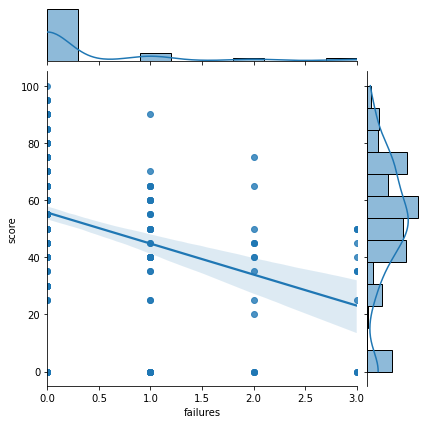

In [105]:
sns.jointplot(x = 'failures', y = 'score', data = df, kind = 'reg')

Все переменные можно охарактеризовать, как слабоскоррелированные. 
Максимальная корреляция наблюдается между fedu и medu (0.58), образование отца и матери. Но это говорит лишь о том, что пары, в основном, создаются людьми со сходными интересами, уровнями культуры, образования и пр.

С целевой переменной наибольшая линейная связь прослеживается у переменной failures (-0.34) - количество внеучебных неудач. Что включает в себя этот фактор - не понятно. Поэтому, какие-то выводы делать сложно.

С целевой перменной коррелируют со значением большим |0.1| переменные: age, address, medu, fedu, studytime, failures, higher, romantic, goout. Кроме romantic (.34) и medu (.2), у перечисленных переменных коэффициенты лежат в пределах 0.1-0.2 по модулю.  

***Причин для исключения каких-либо переменных на основе корреляционного анализа не имеется.***

# Анализ номинативных переменных

Добавим в список номинальных переменных изначально кодированные переменные: 

In [106]:
l1 = ['school',
     'sex',
     'address',
     'famsize',
     'pstatus',
     'medu',
     'fedu',
     'mjob',
     'fjob',
     'reason',
     'guardian',
     'traveltime',
     'studytime',
     'failures',
     'schoolsup',
     'famsup',
     'paid',
     'activities',
     'nursery',
     'higher',
     'internet',
     'romantic',
     'famrel',
     'freetime',
     'goout',
     'health'
    ]

Построим диаграммы box-plot для всех номинативныхных перменных:

In [107]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index)],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

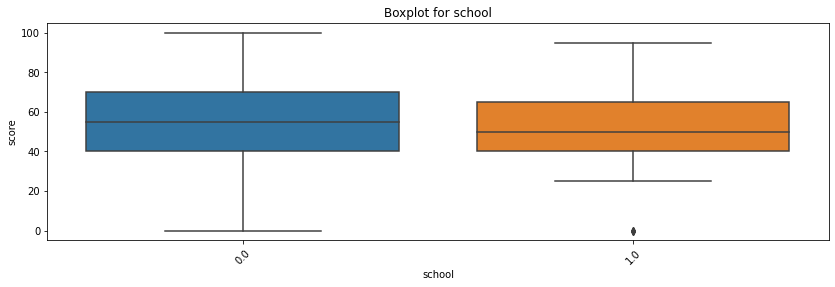

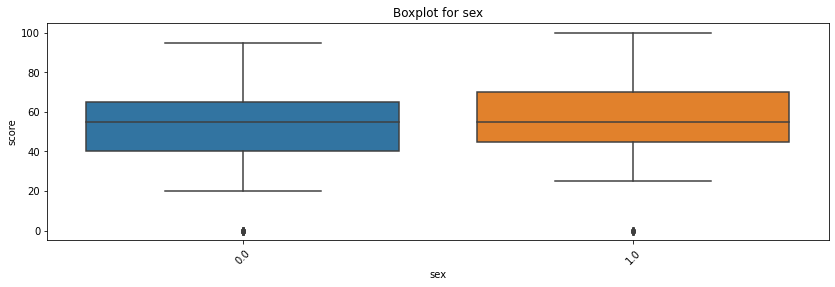

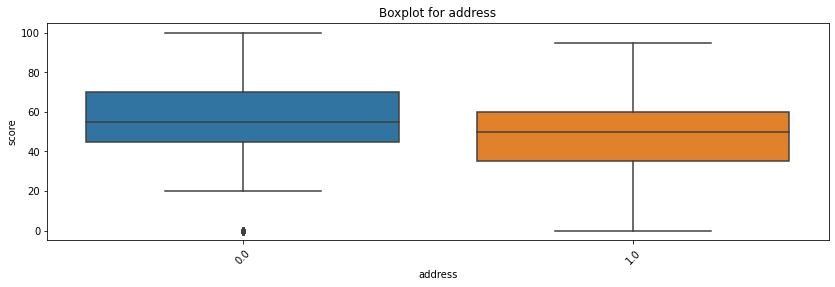

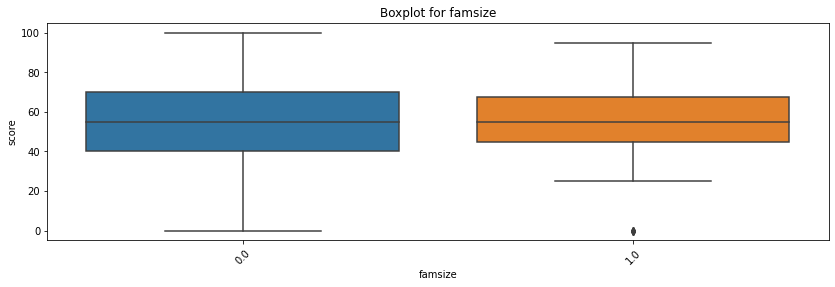

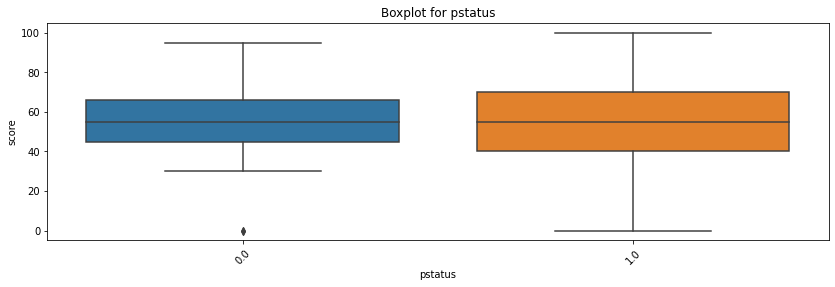

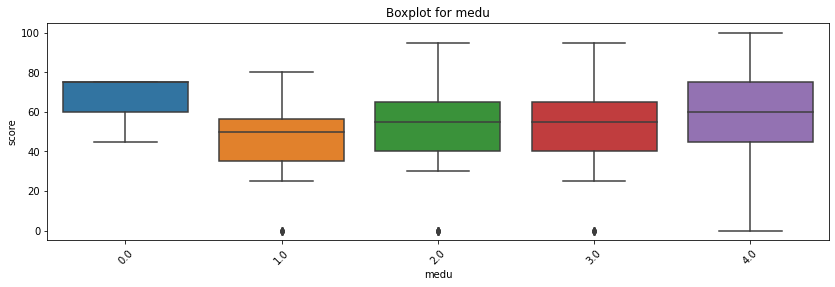

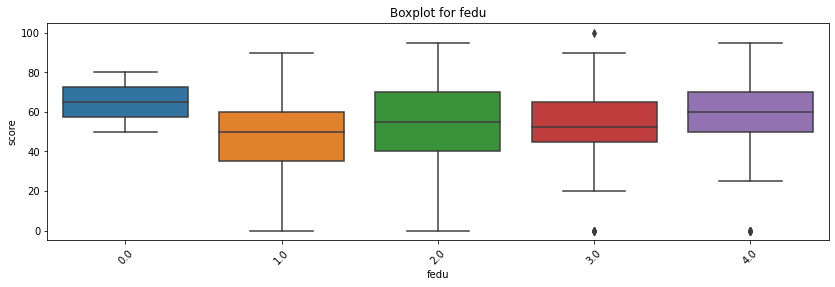

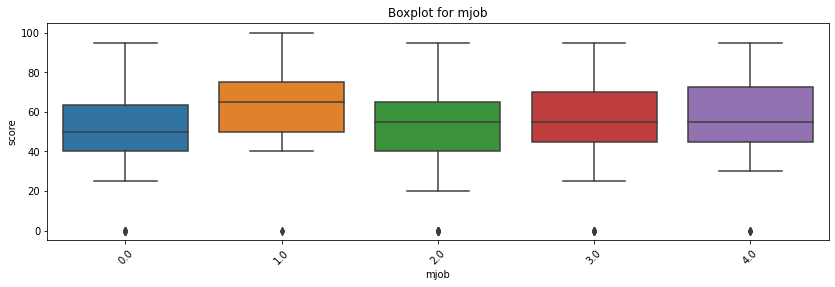

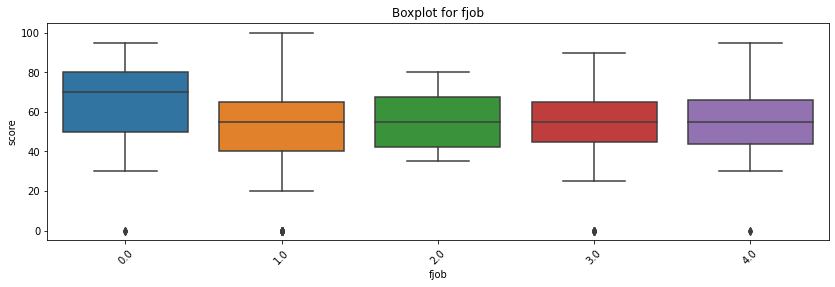

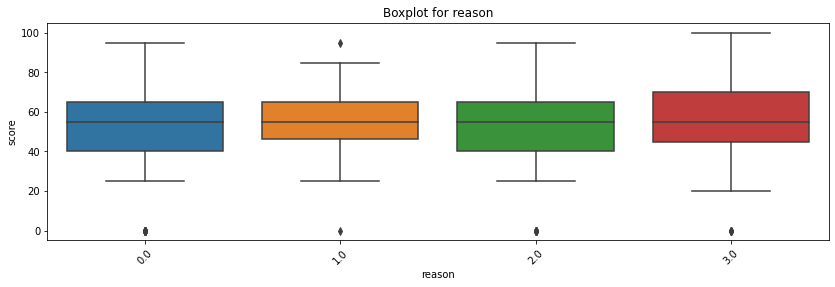

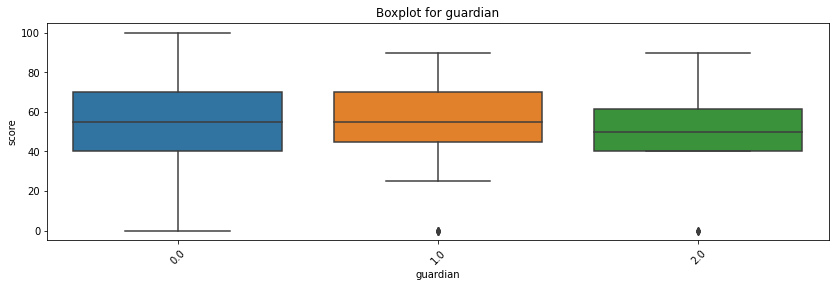

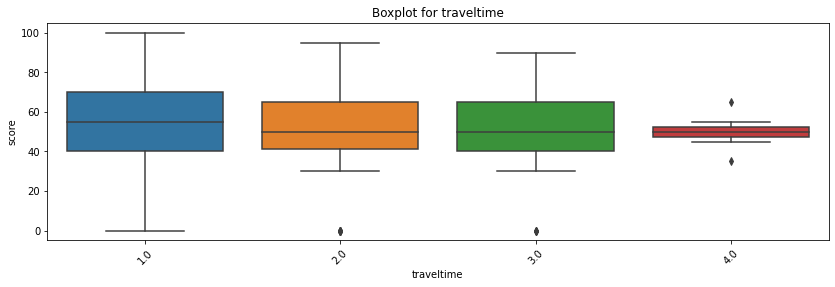

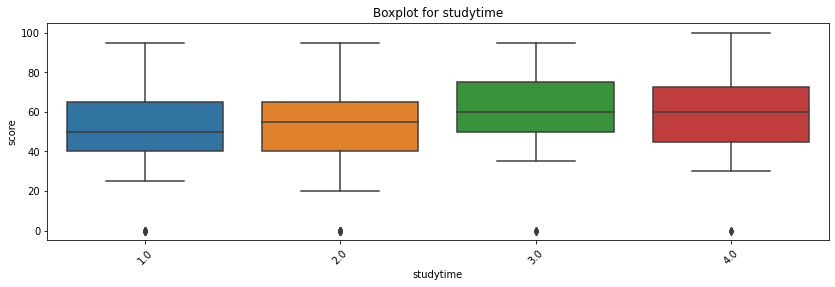

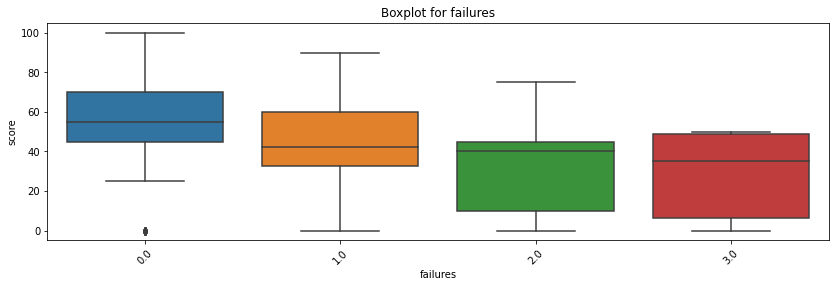

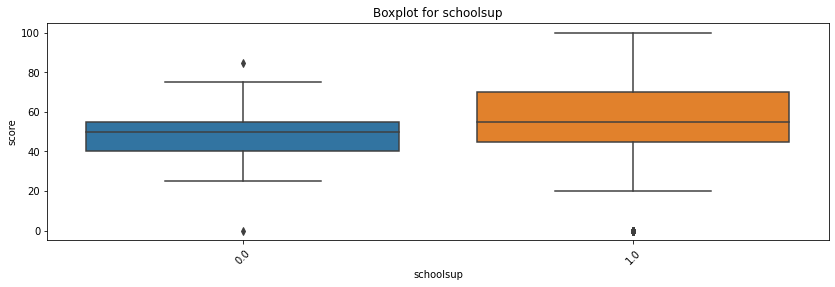

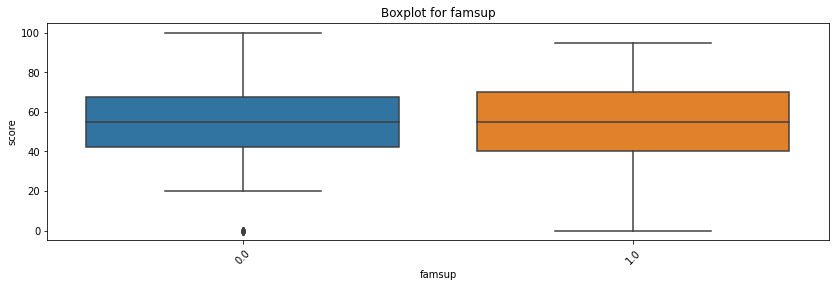

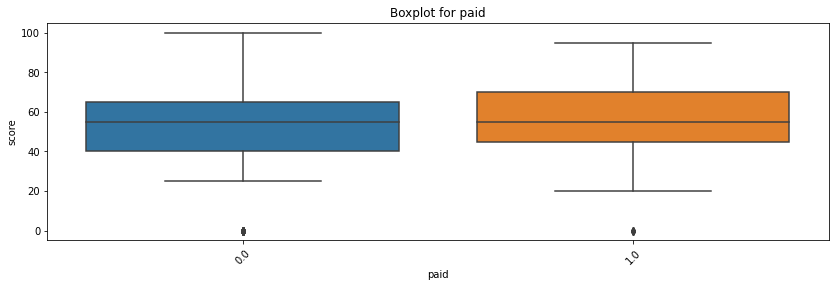

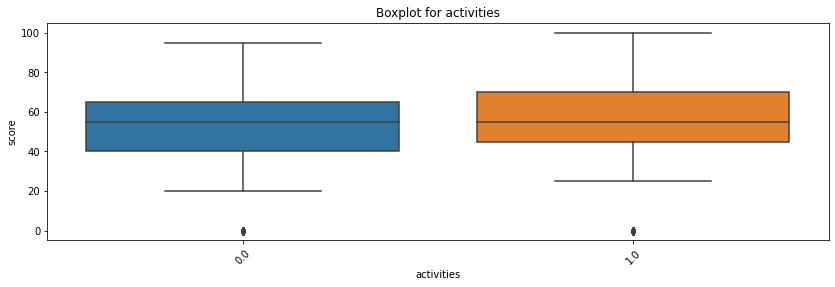

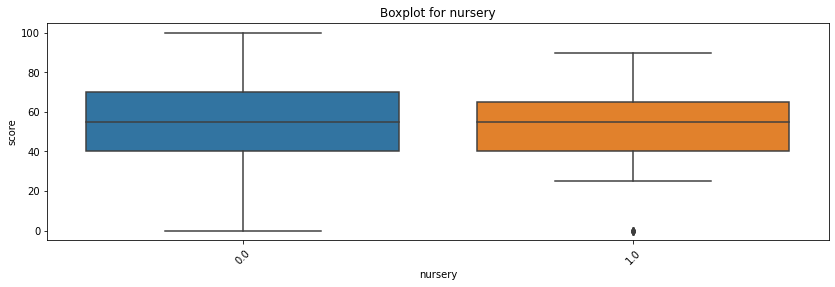

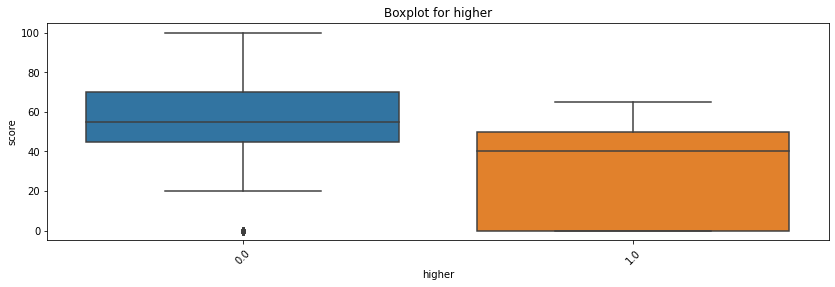

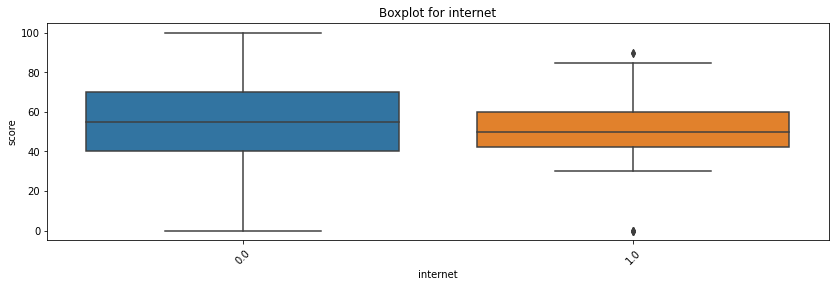

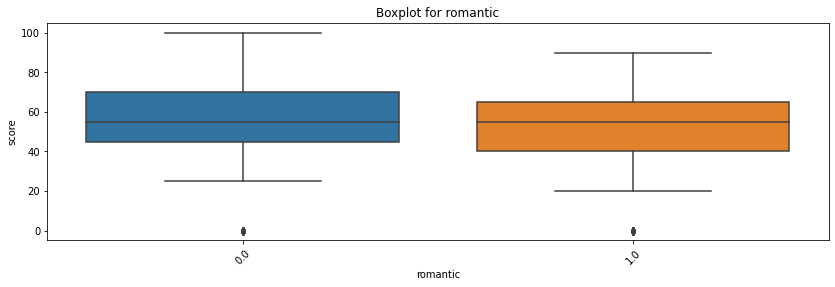

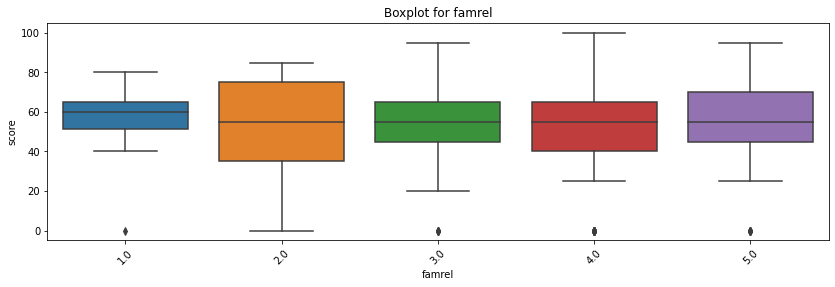

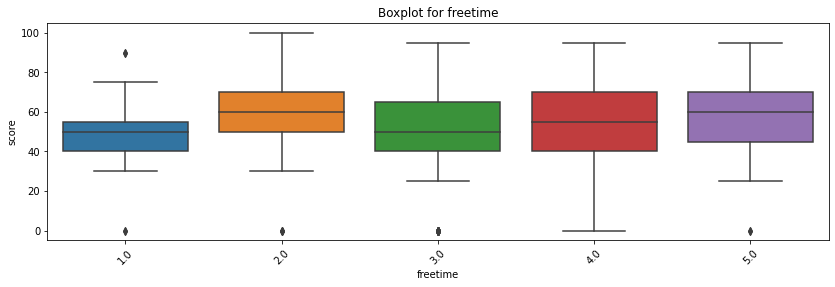

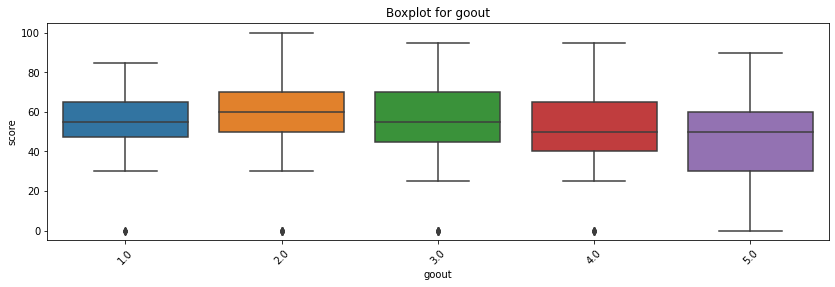

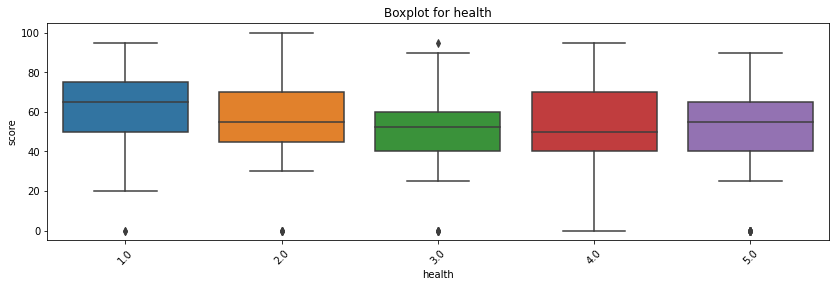

In [108]:
for col in l1:
    get_boxplot(col)

По графикам можно приблизительно предположить, что не влияют на балл на экзамене следующие переменные:
- school
- sex
- famsize
- pstatus
- fjob
- reason
- guardian
- traveltime
- famsup
- paid
- activities
- nursery
- internet
- romantic


Более точную оценку даст парный t-test. 


# T-test

Проверим нулевую гипотезу о том, что распределения баллов за экзамен по различным параметрам неразличимы. Сравним по парам средние для групп баллов за экзамены в зависимости от соответствующих оценочных значений факторов. Берем парные комбинации оценок из каждой переменной и для каждой пары делаем соответствующие срезы значений баллов за экзамен. Оцениваем разницу средних с мопомщью ttest_ind. Если pvalue =< alpha/количество комбинаций, гипотеза отвергается, значимые различия имеются. В обратном случае, различия между целевой переменной и фактором незначительны. 

In [109]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [110]:
for col in l1:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


# Выводы

Для дальнейшего построения модели можно оставить переменные, которые изначально были заданы как числовые, т.к. все они слабо коррелируют с целевой переменной (score):

In [111]:
l3 = list(set(list(df.columns)) - set(l))

In [112]:
l3

['freetime',
 'health',
 'medu',
 'goout',
 'fedu',
 'age',
 'traveltime',
 'absences',
 'score',
 'failures',
 'studytime',
 'famrel']

In [113]:
df[l3].corr()

,freetime,health,medu,goout,fedu,age,traveltime,absences,score,failures,studytime,famrel
freetime,1.000000,0.067629,0.040743,0.294450,-0.022669,0.013994,-0.016696,0.104059,0.017481,0.087558,-0.122057,0.164830
health,0.067629,1.000000,-0.070420,-0.015108,-0.015777,-0.061752,-0.035336,-0.000482,-0.080583,0.079030,-0.063876,0.093256
medu,0.040743,-0.070420,1.000000,0.070310,0.583292,-0.145755,-0.156090,0.053766,0.200890,-0.238295,0.076035,-0.003073
goout,0.294450,-0.015108,0.070310,1.000000,0.046401,0.121057,0.046390,0.094116,-0.127742,0.101036,-0.053554,0.069514
fedu,-0.022669,-0.015777,0.583292,0.046401,1.000000,-0.143849,-0.107267,-0.050786,0.124829,-0.260794,0.011723,-0.015492
age,0.013994,-0.061752,-0.145755,0.121057,-0.143849,1.000000,0.076013,0.119775,-0.155726,0.206279,-0.018019,0.056941
traveltime,-0.016696,-0.035336,-0.156090,0.046390,-0.107267,0.076013,1.000000,-0.033530,-0.056535,0.035113,-0.098226,-0.029213
absences,0.104059,-0.000482,0.053766,0.094116,-0.050786,0.119775,-0.033530,1.000000,0.065986,0.060398,-0.060063,-0.070487
score,0.017481,-0.080583,0.200890,-0.127742,0.124829,-0.155726,-0.056535,0.065986,1.000000,-0.337187,0.114295,0.052902
failures,0.087558,0.079030,-0.238295,0.101036,-0.260794,0.206279,0.035113,0.060398,-0.337187,1.000000,-0.169399,-0.028517


Из номинативных переменных добавляются: address, mjob, higher, romantic

In [114]:
l4 = l3 + ['address', 'mjob', 'higher', 'romantic']

И таким образом, в итоговую модель идут следующие переменные:

In [115]:
l4.remove('score')

In [116]:
l4

['freetime',
 'health',
 'medu',
 'goout',
 'fedu',
 'age',
 'traveltime',
 'absences',
 'failures',
 'studytime',
 'famrel',
 'address',
 'mjob',
 'higher',
 'romantic']

In [117]:
df_for_model = df.loc[:, l4]
df_for_model

,freetime,health,medu,goout,fedu,age,traveltime,absences,failures,studytime,famrel,address,mjob,higher,romantic
0,3.0,3.0,4.0,4.0,4.0,18.0,2.0,6.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0
1,3.0,3.0,1.0,3.0,1.0,17.0,1.0,4.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0
2,3.0,3.0,1.0,2.0,1.0,15.0,1.0,10.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0
3,2.0,5.0,4.0,2.0,2.0,15.0,1.0,2.0,0.0,3.0,3.0,0.0,1.0,0.0,1.0
4,3.0,5.0,3.0,2.0,3.0,16.0,1.0,4.0,0.0,2.0,4.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,5.0,4.0,2.0,4.0,2.0,20.0,1.0,0.0,2.0,2.0,5.0,0.0,3.0,0.0,0.0
391,4.0,2.0,3.0,5.0,1.0,17.0,2.0,3.0,0.0,1.0,2.0,0.0,3.0,0.0,0.0
392,5.0,3.0,1.0,3.0,1.0,21.0,1.0,3.0,3.0,1.0,5.0,1.0,2.0,0.0,0.0
393,4.0,5.0,3.0,1.0,2.0,18.0,3.0,0.0,0.0,1.0,4.0,1.0,3.0,0.0,0.0


Может показаться, что их много. Но, в дальнейшем, их можно, например, сжать до двух факторов методом главных компонент. При этом, значительная часть информации из этих переменных будет сохранена. 